<a href="https://colab.research.google.com/github/jordanbuddenhagen/sales-predicitons/blob/main/Project_1_6_(Core)_JB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [5]:
filename='/content/sales_predictions.csv' 

df = pd.read_csv(filename)

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Clean Data

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [10]:
data_types = df.dtypes
str_cols = data_types[data_types=='object'].index
str_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [11]:
for col in str_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n\n")

- Item_Identifier:
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64



- Item_Fat_Content:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



- Item_Type:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



- Outlet_Identifier:
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    9

In [12]:
replacement_dictionary = {'NaN':3, 'High':2, 'Medium':1, 'Small':0}
df['Outlet_Size'].replace(replacement_dictionary, inplace=True)
df['Outlet_Size']

0       1.0
1       1.0
2       1.0
3       NaN
4       2.0
       ... 
8518    2.0
8519    NaN
8520    0.0
8521    1.0
8522    0.0
Name: Outlet_Size, Length: 8523, dtype: float64

In [13]:
df['Outlet_Size'] = pd.to_numeric(df['Outlet_Size'])

In [14]:
df['Item_Fat_Content']= df['Item_Fat_Content'].replace({'reg': 'Regular', 'low fat': 'Low Fat', 'LF': 'Low Fat'})

In [15]:
#df['Item_Fat_Content']= df['Item_Fat_Content'].replace('low fat', 'Low Fat')  

In [16]:
df['Item_Fat_Content'].value_counts()   #All relevant data should be good to use! 

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Identifying the X and y(Item_Outlet_Sales) 

In [17]:
X=df.drop(columns=['Item_Outlet_Sales', 'Outlet_Establishment_Year', 'Item_Identifier', 'Item_Weight'], axis=1) 

y=df['Item_Outlet_Sales']
# Took out Item Weight and Year of Establishment.  I think unnecessary!?

# Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
X_train.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,Low Fat,0.029565,Household,256.4646,OUT018,1.0,Tier 3,Supermarket Type2
7510,Regular,0.000000,Snack Foods,179.7660,OUT018,1.0,Tier 3,Supermarket Type2
5828,Regular,0.158716,Meat,157.2946,OUT049,1.0,Tier 1,Supermarket Type1
5327,Low Fat,0.014628,Baking Goods,82.3250,OUT035,0.0,Tier 2,Supermarket Type1
4810,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,NaN,Tier 2,Supermarket Type1


# Preprocessing

## I kept it pretty simple.  However, I do not think I needed the mean imputer when taking out Item Weight.  I can add Item Weight back in if needed.

In [20]:
cat_selector=make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [21]:
fre_imputer = SimpleImputer(strategy='constant', fill_value='missing')
mean_imputer = SimpleImputer(strategy='mean') 

scaler= StandardScaler()
ohe=OneHotEncoder(handle_unknown='ignore', sparse_output= False) 




In [22]:
num_pipeline = make_pipeline(mean_imputer, scaler) 

In [23]:
cat_pipeline = make_pipeline(fre_imputer, ohe)

In [24]:
number_tuple = (num_pipeline, num_selector)
cat_tuple = (cat_pipeline, cat_selector)

In [25]:
preprocessor = make_column_transformer(number_tuple, cat_tuple, remainder='passthrough')

In [26]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d7f0454f0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d7ef86a60>)])

In [27]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d7f0454f0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d7ef86a60>)])

In [28]:
X_train_processed = preprocessor.transform(X_train)  


In [29]:
X_test_processed = preprocessor.transform(X_test)

In [30]:
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed


0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 38)




array([[-0.71277507,  1.82810922,  0.40778536, ...,  0.        ,
         1.        ,  0.        ],
       [-1.29105225,  0.60336888,  0.40778536, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.81331864,  0.24454056,  0.40778536, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.92052713,  1.52302674,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.2277552 , -0.38377708,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.95867683, -0.73836105, -1.29162953, ...,  1.        ,
         0.        ,  0.        ]])

# Going to run preprocessed data on models.

In [31]:
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = mean_absolute_error(y_train, pipe.predict(x_train))
  mse = mean_squared_error(y_train, pipe.predict(x_train))
  rmse = np.sqrt(mean_squared_error(y_train, pipe.predict(x_train)))
  r2 = r2_score(y_train, pipe.predict(x_train))
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  ## Test
  mae = mean_absolute_error(y_test, pipe.predict(x_test))
  mse = mean_squared_error(y_test, pipe.predict(x_test))
  rmse = np.sqrt(mean_squared_error(y_test, pipe.predict(x_test)))
  r2 = r2_score(y_test, pipe.predict(x_test))

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [32]:
linreg_model = LinearRegression()
linreg_model_pipe = make_pipeline(preprocessor, linreg_model)

In [33]:
linreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d7f0454f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d7ef86a60>)])),
                ('linearregression', LinearRegression())])

In [34]:
model_metrics(linreg_model_pipe, X_train, y_train, X_test, y_test)

Regression Model Train Scores
MAE: 847.1050 
MSE: 1,297,624.9399 
RMSE: 1,139.1334 
R2: 0.5615

Regression Model Test Scores
MAE: 804.0025 
MSE: 1,194,081.8994 
RMSE: 1,092.7405 
R2: 0.5672



In [35]:
dec_tree_model = DecisionTreeRegressor()
dec_tree_model_pipe = make_pipeline(preprocessor, dec_tree_model)

In [36]:
unlimited_trees = dec_tree_model_pipe.fit(X_train, y_train)

In [37]:
treeTrain_preds = dec_tree_model_pipe.predict(X_train) 
treeTest_preds = dec_tree_model_pipe.predict(X_test)   
#Creating Predictions for our data

In [38]:
 model_metrics(dec_tree_model_pipe, X_train, y_train, X_test, y_test)

Regression Model Train Scores
MAE: 0.0000 
MSE: 0.0000 
RMSE: 0.0000 
R2: 1.0000

Regression Model Test Scores
MAE: 1,041.7920 
MSE: 2,230,246.2599 
RMSE: 1,493.4009 
R2: 0.1916



In [39]:
dec_tree_model_pipe.get_params('decisiontreeregressor__max_depth')

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d7f0454f0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknow

In [40]:
max_depth = unlimited_trees['decisiontreeregressor'].get_depth()
max_depth

39

In [41]:
depths = range(1, max_depth+1)


depth_scores = pd.DataFrame(columns=['Train Score', 'Test Score'], index=depths)

for depth in depths:
  dec_Tree = DecisionTreeRegressor(max_depth=depth) 
  dec_TreePipe = make_pipeline(preprocessor, dec_Tree)

  dec_TreePipe.fit(X_train, y_train)

  TrainPreds = dec_TreePipe.predict(X_train)
  TestPreds = dec_TreePipe.predict(X_test)

  train_r2 = r2_score(y_train, TrainPreds)
  test_r2 = r2_score(y_test, TestPreds)

  depth_scores.loc[depth, 'Train Score'] = train_r2
  depth_scores.loc[depth, 'Test Score'] = test_r2

print(depth_scores)

   Train Score Test Score
1     0.237797   0.229683
2     0.431641   0.433778
3     0.524218   0.524222
4     0.582625   0.584005
5     0.603925   0.594747
6     0.614966   0.583592
7     0.626356   0.580245
8      0.64257   0.561732
9     0.665117   0.549086
10    0.687572   0.535859
11    0.715275   0.495239
12    0.741341   0.472174
13    0.772198    0.44011
14    0.801674   0.393713
15    0.831518   0.375867
16    0.856489   0.350526
17    0.879689   0.316916
18    0.900521   0.314213
19     0.92063   0.293017
20    0.937726   0.264619
21    0.952981   0.240072
22    0.964977    0.23085
23    0.973201   0.221576
24     0.98109   0.214868
25    0.986278   0.201683
26     0.98973   0.209759
27     0.99286   0.184137
28    0.994766   0.203705
29    0.995791   0.221691
30    0.996527   0.210047
31     0.99767   0.192491
32    0.998593   0.206396
33    0.999014   0.208412
34    0.999468   0.195435
35    0.999759   0.182669
36    0.999918   0.190908
37    0.999986   0.203539
38         1

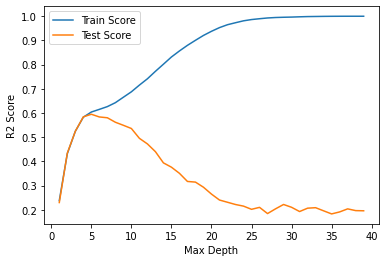

In [42]:
plt.plot(depths, depth_scores['Train Score'], label='Train Score')
plt.plot(depths, depth_scores['Test Score'], label='Test Score')
plt.ylabel('R2 Score')
plt.xlabel('Max Depth')
plt.legend()
plt.show()


In [43]:
sorted = depth_scores.sort_values(by='Test Score', ascending=False)

sorted.head()

,Train Score,Test Score
5,0.603925,0.594747
4,0.582625,0.584005
6,0.614966,0.583592
7,0.626356,0.580245
8,0.64257,0.561732


In [44]:
bestTree=sorted.index[0]
#bestTree

In [45]:
best_dt=DecisionTreeRegressor(max_depth=bestTree)
best_dtpipe=make_pipeline(preprocessor, best_dt)

best_dtpipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d7f0454f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8d7ef86a60>)])),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=5))])

In [46]:
model_metrics(best_dtpipe, X_train, y_train, X_test, y_test)

Regression Model Train Scores
MAE: 762.5844 
MSE: 1,172,164.9689 
RMSE: 1,082.6657 
R2: 0.6039

Regression Model Test Scores
MAE: 738.3376 
MSE: 1,118,083.6842 
RMSE: 1,057.3948 
R2: 0.5947



In [47]:
model_metrics(linreg_model_pipe, X_train, y_train, X_test, y_test)

Regression Model Train Scores
MAE: 847.1050 
MSE: 1,297,624.9399 
RMSE: 1,139.1334 
R2: 0.5615

Regression Model Test Scores
MAE: 804.0025 
MSE: 1,194,081.8994 
RMSE: 1,092.7405 
R2: 0.5672



## I would recommend the tuned decision tree model.  
  - MAE and RMSE are both lower for the decision tree and make sense when compared to dollars.
  - R2 has a higher score in Regression Tree model and has an okay fit. 
  - Item Sales Outlook will have a better prediciton model with the decison tree!  